In [1]:
# make sure changes in code take place immediately
%load_ext autoreload
%autoreload 2
import pandas as pd # occasionally this would get left out
    
# load the chapyter extension for Jupyter Notebook
%load_ext chapyter

In [2]:
#Define the notebook name as a variable
import os
os.environ["NOTEBOOK_NAME"] = "demo_chloe.ipynb"


## Mocha Demo V1

Our goal is to replicate the findings in this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6687414/pdf/shk-52-146.pdf

Hypothesis: Gender is associated with in-hospital mortality and LOS in patients with sepsis admitted to the ICU

* 1 - get data from mimic 
* 2 - build a basic table 1 to summarize the data [ICU Service, Admission Location, Ethnicity], adding in a few of our own variables (lactate, creatinine)
* 3 - do a univariate analysis to understand if the groups are similar or different
* 4 - build a kaplan-meier curve for in-hospital mortality 
* 5 - do a univariate cox proportional hazard model to understand if men or women are more likely to die in-hospital 
* 6 - redo the analysis, but controlling for significant factors from our univariate analysis

## Step 1: Get data from MIMIC 
1. Get patients from MIMIC diagnosed with sepsis, severe sepsis, or septic shock.
2. Apply exclusion criteria – only get patients 18+. Only get patients admitted to the ICU. Only include a patient's first ICU admission.
3. Add a few variables – ethnicity, ICU Service, admission type, first ICU service, date of ICU admission and discharge
4. Add relevant labs (lactate, creatinine)

In [3]:
%%mimicSQL 

I'd like to study if there is an association between sex and in-hospital mortality in patients with sepsis admitted to the ICU.
Can you get me all the patients admitted to an ICU with sepsis, severe sepsis, or septic shock that are 18 or older, as well as their admit times, discharge time, and time of death? 
I'd also like to add a few variables – can you include the following variables in the data frame? 
- ethnicity
- the first ICU service the patient was admitted to
- admission type

Remember that every column in the SELECT clause must be part of an aggregate function or listed in the GROUP BY clause. 

Sure, I can help with that. We will need to join several tables to get all the information you need. We will use the `diagnoses_icd` table to identify patients with sepsis, severe sepsis, or septic shock using the relevant ICD-9 codes (995.91, 995.92, 785.52). We will also use the `patients` table to get the sex and ethnicity of the patients, the `admissions` table to get the admission and discharge times, and the `icustays` table to get the first ICU service the patient was admitted to. Here is the SQL query:

This query will return a data frame with the patient ID, sex, date of birth, hospital admission ID, admission time, discharge time, time of death, admission type, ethnicity, and the first ICU service the patient was admitted to for all patients aged 18 or older who were admitted to an ICU with sepsis, severe sepsis, or septic shock.


In [4]:
%%runSQL 


SELECT 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit
FROM 
    patients p
JOIN 
    admissions a ON p.subject_id = a.subject_id
JOIN 
    icustays i ON a.hadm_id = i.hadm_id
JOIN 
    diagnoses_icd d ON a.hadm_id = d.hadm_id
WHERE 
    d.icd9_code IN ('99591', '99592', '78552')
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18
GROUP BY 
    p.subject_id,
    p.gender,
    p.dob,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit
0,66876,M,2057-06-23 00:00:00.000,122645,2133-02-09 14:00:00.000,2133-02-20 13:38:00.000,2133-02-20 13:38:00.000,ELECTIVE,WHITE,CSRU
1,66894,F,2069-03-07 00:00:00.000,157688,2126-08-10 21:10:00.000,2126-08-11 19:29:00.000,2126-08-11 19:29:00.000,EMERGENCY,HISPANIC OR LATINO,MICU
2,66965,M,2116-06-07 00:00:00.000,177338,2198-01-22 22:20:00.000,2198-02-14 14:51:00.000,None,EMERGENCY,WHITE,CCU
3,67050,M,2143-08-27 00:00:00.000,135268,2200-02-10 02:07:00.000,2200-02-21 00:45:00.000,2200-02-21 00:45:00.000,EMERGENCY,HISPANIC/LATINO - PUERTO RICAN,MICU
4,67104,F,2053-12-18 00:00:00.000,116413,2134-09-09 03:27:00.000,2134-10-30 20:11:00.000,2134-10-30 20:11:00.000,EMERGENCY,OTHER,MICU


In [9]:
%%mimicSQL 

Great. Now I'd like to get the same patients, but only select their first ICU admission in the database. 

Sure, to get the first ICU admission for each patient, we can modify the previous query to include a subquery that selects the minimum `intime` for each `subject_id` from the `icustays` table. Here is the updated SQL query:

This query will return the same information as the previous one, but only for the first ICU admission of each patient.


In [5]:
%%runSQL 


SELECT 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit
FROM 
    patients p
JOIN 
    admissions a ON p.subject_id = a.subject_id
JOIN 
    icustays i ON a.hadm_id = i.hadm_id
JOIN 
    diagnoses_icd d ON a.hadm_id = d.hadm_id
WHERE 
    d.icd9_code IN ('99591', '99592', '78552')
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18
    AND i.intime = (
        SELECT MIN(intime)
        FROM icustays
        WHERE subject_id = p.subject_id
    )
GROUP BY 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit


,subject_id,gender,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit
0,797,M,100863,2139-08-24 22:00:00.000,2139-08-29 14:45:00.000,None,EMERGENCY,WHITE,MICU
1,38,M,185910,2166-08-10 00:28:00.000,2166-09-04 11:30:00.000,None,EMERGENCY,WHITE,CCU
2,195,F,118936,2167-11-29 16:25:00.000,2167-12-23 12:20:00.000,None,ELECTIVE,WHITE,CSRU
3,406,F,113900,2119-08-25 22:37:00.000,2119-09-01 18:00:00.000,None,EMERGENCY,WHITE,MICU
4,430,F,110233,2155-09-16 00:14:00.000,2155-09-16 10:30:00.000,2155-09-16 10:30:00.000,EMERGENCY,WHITE,MICU


In [25]:
%%mimicSQL
Perfect. Now can we add two things to that data frame (without changing the number of entries): 
- the patient's first lactate of that ICU admission
- the patient's first creatinine of that ICU admission
The number of rows should stay the same, we simply want to add those two lab values to the existing table. 

Sure, to add the first lactate and creatinine values of each patient's ICU admission, we can join the `labevents` table on `subject_id` and `hadm_id`. We'll also need to add a subquery to select the minimum `charttime` for each `subject_id` and `itemid` for lactate and creatinine. The `itemid` for lactate is typically 50813 and for creatinine it's 50912. Here is the updated SQL query:

This query will return the same information as the previous one, but with the addition of the first lactate and creatinine values of each patient's ICU admission.


In [6]:
%%runSQL 


SELECT 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit,
    l1.valuenum AS first_lactate,
    l2.valuenum AS first_creatinine
FROM 
    patients p
JOIN 
    admissions a ON p.subject_id = a.subject_id
JOIN 
    icustays i ON a.hadm_id = i.hadm_id
JOIN 
    diagnoses_icd d ON a.hadm_id = d.hadm_id
LEFT JOIN 
    (SELECT subject_id, hadm_id, valuenum, charttime
    FROM labevents
    WHERE itemid = 50813
    AND charttime = (
        SELECT MIN(charttime)
        FROM labevents
        WHERE subject_id = p.subject_id
        AND itemid = 50813
    )) l1 ON p.subject_id = l1.subject_id AND a.hadm_id = l1.hadm_id
LEFT JOIN 
    (SELECT subject_id, hadm_id, valuenum, charttime
    FROM labevents
    WHERE itemid = 50912
    AND charttime = (
        SELECT MIN(charttime)
        FROM labevents
        WHERE subject_id = p.subject_id
        AND itemid = 50912
    )) l2 ON p.subject_id = l2.subject_id AND a.hadm_id = l2.hadm_id
WHERE 
    d.icd9_code IN ('99591', '99592', '78552')
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18
    AND i.intime = (
        SELECT MIN(intime)
        FROM icustays
        WHERE subject_id = p.subject_id
    )
GROUP BY 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit,
    l1.valuenum,
    l2.valuenum


Query failed! State: FAILED
Reason: COLUMN_NOT_FOUND: line 28:28: Column 'p.subject_id' cannot be resolved or requester is not authorized to access requested resources


AttributeError: 'bool' object has no attribute 'head'

Was tempted to now calculate SOFA score but we can wait to do that for the next iteration of the demo because it depends on a lot of other calculated measures that get pretty complicated. 

In [27]:
%%mimicSQL
I get the following error: Query failed! State: FAILED
Reason: COLUMN_NOT_FOUND: line 28:28: Column 'p.subject_id' cannot be resolved or requester is not authorized to access requested resources
Can you fix the error and produce new SQL that pulls the labs I'm interested in ?

I apologize for the confusion. The error is due to the subquery not recognizing the alias 'p' for the patients table. We need to modify the subquery to include the patients table and join it on subject_id. Here is the corrected SQL:

This query should return the same number of rows as the previous one, but with the addition of the first lactate and creatinine values of each patient's ICU admission.


In [7]:
%%runSQL 


SELECT 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit,
    l1.valuenum AS first_lactate,
    l2.valuenum AS first_creatinine
FROM 
    patients p
JOIN 
    admissions a ON p.subject_id = a.subject_id
JOIN 
    icustays i ON a.hadm_id = i.hadm_id
JOIN 
    diagnoses_icd d ON a.hadm_id = d.hadm_id
LEFT JOIN 
    (SELECT le.subject_id, le.hadm_id, le.valuenum, le.charttime
    FROM labevents le
    JOIN patients p ON le.subject_id = p.subject_id
    WHERE le.itemid = 50813
    AND le.charttime = (
        SELECT MIN(charttime)
        FROM labevents
        WHERE subject_id = le.subject_id
        AND itemid = 50813
    )) l1 ON p.subject_id = l1.subject_id AND a.hadm_id = l1.hadm_id
LEFT JOIN 
    (SELECT le.subject_id, le.hadm_id, le.valuenum, le.charttime
    FROM labevents le
    JOIN patients p ON le.subject_id = p.subject_id
    WHERE le.itemid = 50912
    AND le.charttime = (
        SELECT MIN(charttime)
        FROM labevents
        WHERE subject_id = le.subject_id
        AND itemid = 50912
    )) l2 ON p.subject_id = l2.subject_id AND a.hadm_id = l2.hadm_id
WHERE 
    d.icd9_code IN ('99591', '99592', '78552')
    AND DATE_DIFF('year', p.dob, a.admittime) >= 18
    AND i.intime = (
        SELECT MIN(intime)
        FROM icustays
        WHERE subject_id = p.subject_id
    )
GROUP BY 
    p.subject_id,
    p.gender,
    a.hadm_id,
    a.admittime,
    a.dischtime,
    a.deathtime,
    a.admission_type,
    a.ethnicity,
    i.first_careunit,
    l1.valuenum,
    l2.valuenum


,subject_id,gender,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit,first_lactate,first_creatinine
0,1601,M,100160,2153-02-03 21:49:00.000,2153-02-07 15:30:00.000,None,EMERGENCY,WHITE,MICU,1.3,1.1
1,1886,M,162771,2183-04-25 10:40:00.000,2183-05-08 11:14:00.000,2183-05-08 11:14:00.000,EMERGENCY,WHITE,CCU,1.8,0.9
2,1918,M,132428,2107-04-08 07:03:00.000,2107-04-14 13:00:00.000,None,EMERGENCY,WHITE,MICU,1.0,None
3,4272,F,196156,2195-09-14 22:25:00.000,2195-09-26 12:45:00.000,2195-09-26 12:45:00.000,EMERGENCY,WHITE,TSICU,1.8,None
4,4457,M,163341,2158-10-17 07:15:00.000,2158-10-31 15:20:00.000,None,ELECTIVE,WHITE,CSRU,4.6,1.4


Unfortunately could only get this working by allowing it to produce non-functional code and then getting it to fix the error. But I think it's sort of cool to see it fixing its own error (eventually this is the sort of thing that can be handled behind the scenes with agents)

In [11]:
%%mimicPython
How many unique patients do I have in my dataset? And are there any duplicated patients? I should have only have one entry per patient. 

In [12]:
##AI-generated-code


import pandas as pd

# Count the number of unique patients
num_unique_patients = df['subject_id'].nunique()
print("Number of unique patients: ", num_unique_patients)

# Check for duplicate patients
duplicate_patients = df.duplicated(subset='subject_id', keep=False).sum()
print("Number of duplicated patients: ", duplicate_patients)


Number of unique patients:  3504
Number of duplicated patients:  0


In [13]:
%%mimicPython
Write code to make histograms of the first creatinine and first lactate values (two separate plots) in df, breaking the lab values into 20 bins or so.
Be sure to check the column names to make sure that they match exactly and exclude NA values. Be sure to \
    convert the lab values into numeric data types if they aren't numeric already. Do not modify the original \
    dataframe (df). 

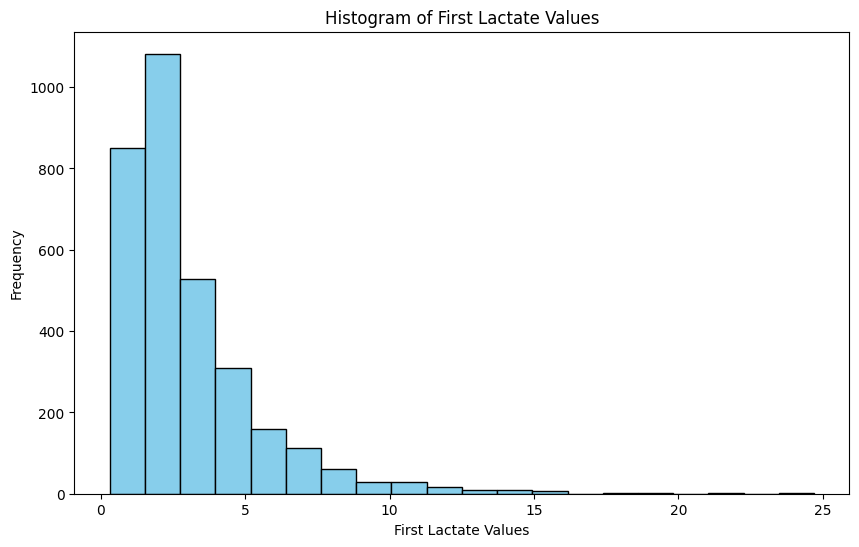

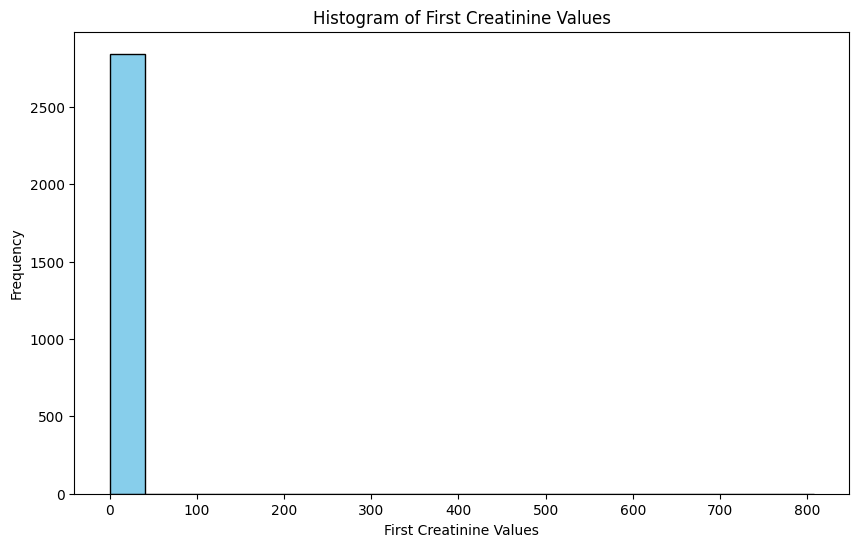

In [14]:
##AI-generated-code


import matplotlib.pyplot as plt

# Convert the lab values into numeric data types
df['first_lactate'] = pd.to_numeric(df['first_lactate'], errors='coerce')
df['first_creatinine'] = pd.to_numeric(df['first_creatinine'], errors='coerce')

# Exclude NA values
df_lactate = df['first_lactate'].dropna()
df_creatinine = df['first_creatinine'].dropna()

# Plot histogram for first lactate values
plt.figure(figsize=(10, 6))
plt.hist(df_lactate, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of First Lactate Values')
plt.xlabel('First Lactate Values')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for first creatinine values
plt.figure(figsize=(10, 6))
plt.hist(df_creatinine, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of First Creatinine Values')
plt.xlabel('First Creatinine Values')
plt.ylabel('Frequency')
plt.show()


In [15]:
%%mimicPython --model gpt-3.5-turbo

Can you tell me how many patients have a creatinine over 20? 

In [16]:
##AI-generated-code


# Count the number of patients with a creatinine over 20
num_patients_high_creatinine = df[df['first_creatinine'] > 20]['subject_id'].count()
print("Number of patients with a creatinine over 20: ", num_patients_high_creatinine)


Number of patients with a creatinine over 20:  2


In [31]:
%%mimicPython
Now can we plot the lactate vs. creatinine values for each patient? If a value of lactate or creatinine is missing for one subject, \
exclude them from the scatter plot entirely. Also exclude subjects with a creatinine >20. Make the points very, very small (the \
minimum number of pixels in order to just be visible) to minimize overlap. Lactate should be on the X axis and creatinine should be on the Y axis.

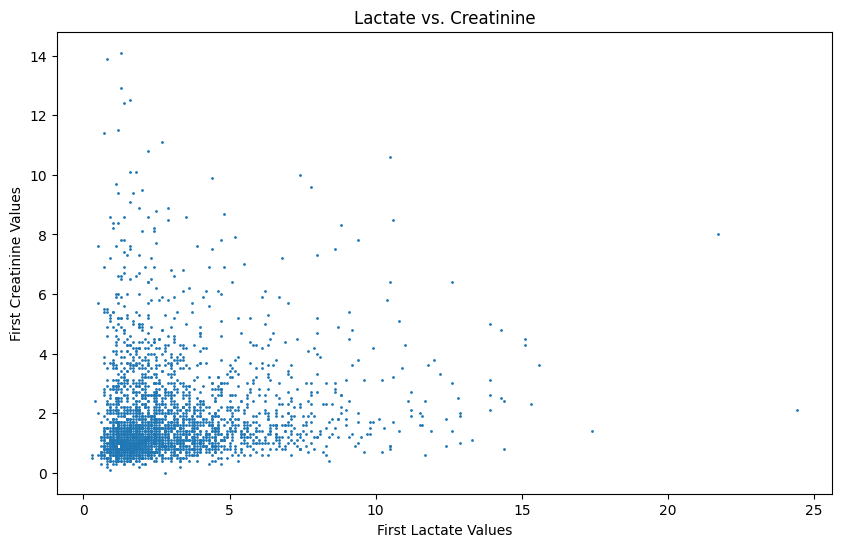

In [32]:
##AI-generated-code

##AI-generated-code --- 
import matplotlib.pyplot as plt

# Exclude subjects with missing values and creatinine > 20
df_filtered = df.dropna(subset=['first_lactate', 'first_creatinine'])
df_filtered = df_filtered[df_filtered['first_creatinine'] <= 20]

# Plot lactate vs. creatinine
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['first_lactate'], df_filtered['first_creatinine'], s=1)
plt.title('Lactate vs. Creatinine')
plt.xlabel('First Lactate Values')
plt.ylabel('First Creatinine Values')
plt.show()